In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import aubio
import matplotlib.pyplot as plt
import pandas as pd
import glob

from IPython import display
from pathlib import PurePath

from vxs import *

In [2]:
BEATBOXSET1_DIR = '../data/beatboxset1'
AVP_DIR = '../data/AVP_Dataset'

plt.rcParams.update({'font.size': 16})    

def plot_track(track, onsets=None, event_type=None, title=None, return_events=False):
    fig = plt.figure(figsize=(20, 5))
    plt.plot(np.linspace(0, track.duration, track.n_samples), track.wave)
    
    events = []
    if onsets is not None:
        for (idx, row) in onsets.iterrows():
            if event_type is None or row['class'] == event_type:
                events.append(row['time'])
                plt.axvline(x=row['time'], color='r')
                
    plt.ylim((-1.5, 1.5))
    plt.xlabel('Time, seconds')
    plt.ylabel('Signal amplitude')
    if title is not None:
        plt.title(title)
    plt.show()
    
    if return_events:
        return events

In [3]:
beatboxset1_DR = Beatbox1TrackSet(BEATBOXSET1_DIR, annotation_type='DR')
beatboxset1_HT = Beatbox1TrackSet(BEATBOXSET1_DIR, annotation_type='HT')

In [4]:
track_sh, onsets_DR = beatboxset1_DR.get('snare_hex')
_, onsets_HT = beatboxset1_HT.get('snare_hex')

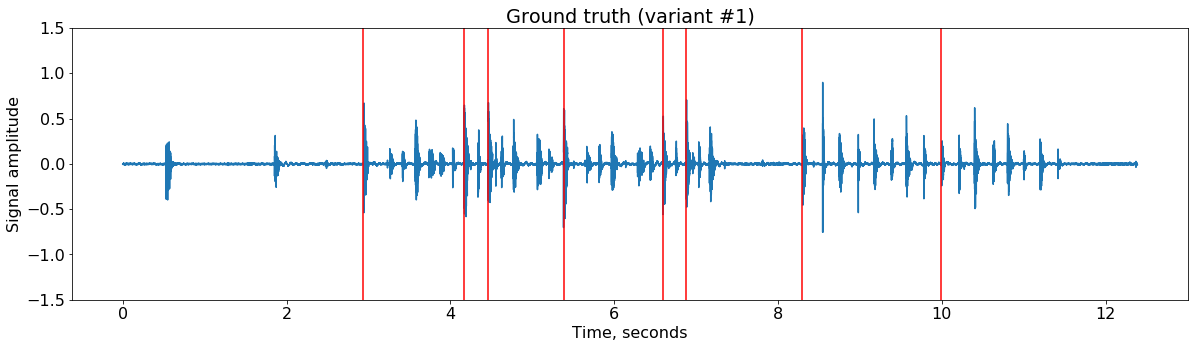

In [5]:
kick_events = plot_track(track_sh, onsets=onsets_DR, event_type='k', title='Ground truth (variant #1)', return_events=True)

In [6]:
segm = track_sh.segment(kick_events[2], 0.05)

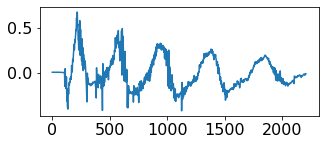

In [7]:
fig = plt.figure(figsize=(5,2))
plt.plot(np.arange(len(segm)), segm)

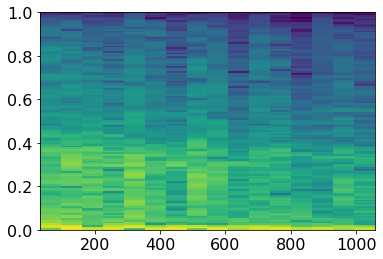

In [8]:
_ = plt.specgram(segm, Fs=2)

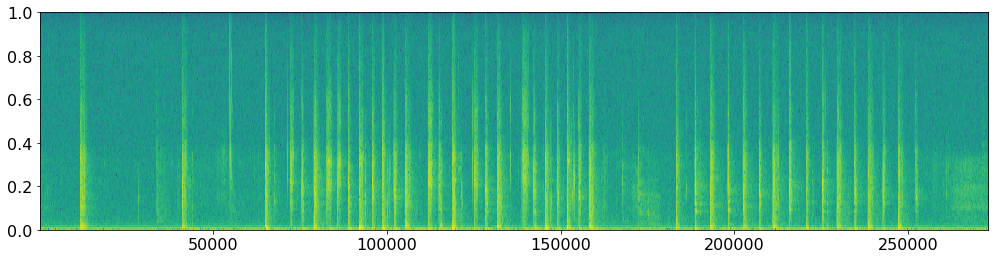

In [9]:
fig = plt.figure(figsize=(17,4))
_ = plt.specgram(track_sh.wave, Fs=2)

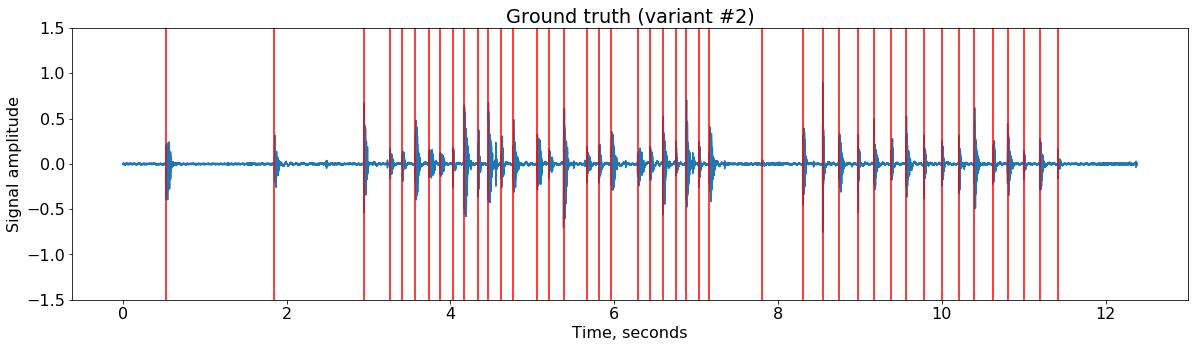

In [10]:
plot_track(track_sh, onsets=onsets_HT, title='Ground truth (variant #2)')

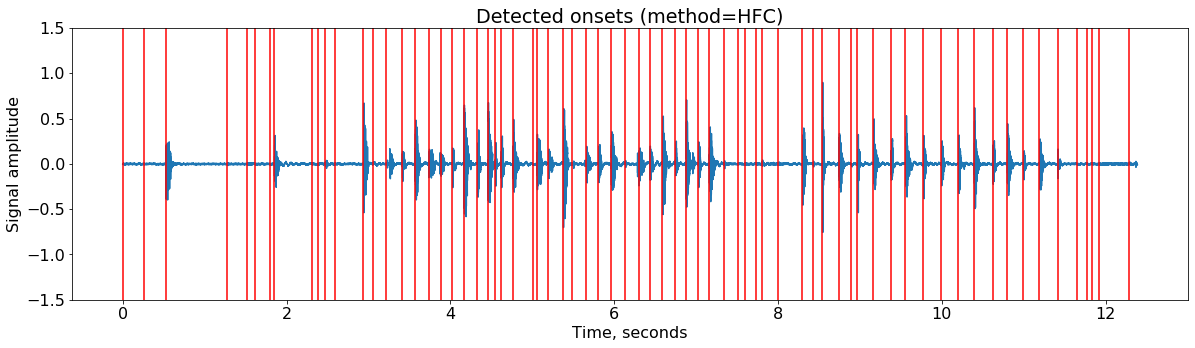

In [11]:
onsets_detected_hfc = detect_onsets(track_sh, method='hfc')
plot_track(track_sh, onsets=onsets_detected_hfc, title='Detected onsets (method=HFC)')

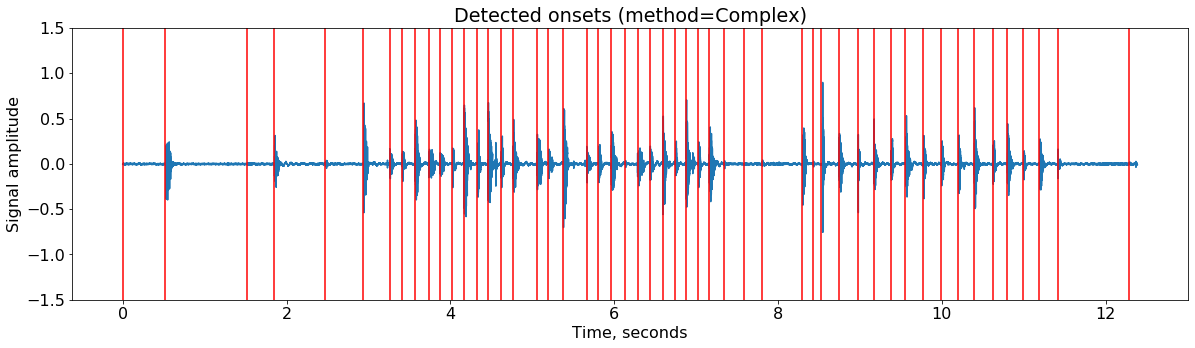

In [12]:
onsets_detected_cp = detect_onsets(track_sh, method='complex')
plot_track(track_sh, onsets=onsets_detected_cp, title='Detected onsets (method=Complex)')

In [13]:
onsets_F1_score(onsets_DR['time'].values, onsets_detected_hfc['time'], ms_threshold=10)

0.6837606837606838

In [14]:
scores_DR = dataset_onset_scores(beatboxset1_DR)
scores_HT = dataset_onset_scores(beatboxset1_HT)

In [17]:
bbs_scores = pd.merge(scores_DR, scores_HT, on='track', suffixes=('_DR', '_HT'))

In [18]:
bbs_scores

,track,HFC_F1_DR,HFC_prec_DR,HFC_rec_DR,Complex_F1_DR,Complex_prec_DR,Complex_rec_DR,HFC_F1_HT,HFC_prec_HT,HFC_rec_HT,Complex_F1_HT,Complex_prec_HT,Complex_rec_HT
0,putfile_bui,0.901564,0.829103,0.987903,0.921624,0.866785,0.983871,0.892606,0.857868,0.930275,0.915162,0.900533,0.930275
1,snare_hex,0.752137,0.619718,0.956522,0.877551,0.826923,0.934783,0.765217,0.619718,1.000000,0.916667,0.846154,1.000000
2,putfile_william,0.954424,0.927083,0.983425,0.988950,0.988950,0.988950,0.957219,0.932292,0.983516,0.991736,0.994475,0.989011
3,callout_Turn-Table,0.907801,0.836601,0.992248,0.933824,0.888112,0.984496,0.914676,0.875817,0.957143,0.932862,0.923077,0.942857
4,callout_adiao,0.971751,0.959108,0.984733,0.971319,0.973180,0.969466,0.965909,0.947955,0.984556,0.965385,0.961686,0.969112
5,callout_luckeymonkey,0.946136,0.935185,0.957346,0.942928,0.989583,0.900474,0.953052,0.939815,0.966667,0.945274,0.989583,0.904762
6,callout_mcld,0.859375,0.774648,0.964912,0.933333,0.925287,0.941520,0.863874,0.774648,0.976331,0.938776,0.925287,0.952663
7,callout_azeem,0.585470,0.782857,0.467577,0.558036,0.806452,0.426621,0.584746,0.788571,0.464646,0.561947,0.819355,0.427609
8,battleclip_daq,0.941989,0.921622,0.963277,0.939007,0.943020,0.935028,0.916667,0.891892,0.942857,0.924394,0.923077,0.925714
9,callout_mouss,0.944444,0.916168,0.974522,0.948718,0.954839,0.942675,0.937500,0.898204,0.980392,0.941558,0.935484,0.947712


In [60]:
#scores[['track', 'DR_HFC_F1', 'DR_Complex_F1', 'HT_HFC_F1', 'HT_Complex_F1']].to_clipboard()

In [19]:
bbs_scores.mean()

HFC_F1_DR          0.876509
HFC_prec_DR        0.850209
HFC_rec_DR         0.923247
Complex_F1_DR      0.901529
Complex_prec_DR    0.916313
Complex_rec_DR     0.900788
HFC_F1_HT          0.875147
HFC_prec_HT        0.852678
HFC_rec_HT         0.918638
Complex_F1_HT      0.903376
Complex_prec_HT    0.921871
Complex_rec_HT     0.898972
dtype: float64

In [20]:
bbs_scores.std()

HFC_F1_DR          0.120630
HFC_prec_DR        0.104585
HFC_rec_DR         0.160629
Complex_F1_DR      0.124222
Complex_prec_DR    0.066219
Complex_rec_DR     0.168976
HFC_F1_HT          0.117882
HFC_prec_HT        0.100913
HFC_rec_HT         0.160878
Complex_F1_HT      0.122165
Complex_prec_HT    0.056114
Complex_rec_HT     0.168103
dtype: float64

In [21]:
def prec_rec_bar_plot(scores, labels, precs, recs, title='precision/recall'):
    mean_scores = scores.mean()
    precisions = mean_scores[precs]
    recalls = mean_scores[recs]
    
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2, precisions, width, label='Precision')
    rects2 = ax.bar(x + width/2, recalls, width, label='Recall')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

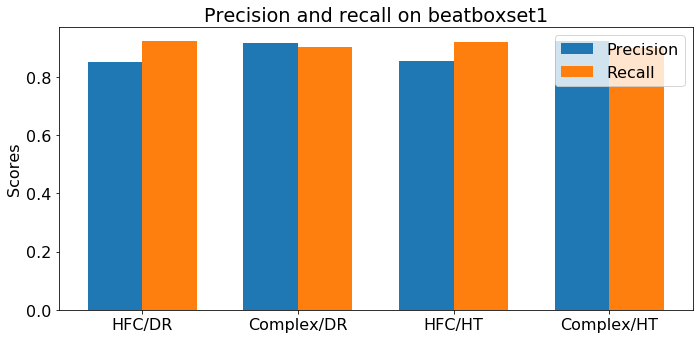

In [22]:
labels = ['HFC/DR', 'Complex/DR', 'HFC/HT', 'Complex/HT']
precs = ['HFC_prec_DR', 'Complex_prec_DR', 'HFC_prec_HT', 'Complex_prec_HT']
recs = ['HFC_rec_DR', 'Complex_rec_DR', 'HFC_rec_HT', 'Complex_rec_HT']

prec_rec_bar_plot(bbs_scores, labels, precs, recs, title='Precision and recall on beatboxset1')

In [24]:
avp_set = AVPTrackSet(AVP_DIR)
avp_scores = dataset_onset_scores(avp_set)

In [25]:
avp_scores

,track,HFC_F1,HFC_prec,HFC_rec,Complex_F1,Complex_prec,Complex_rec
0,P8_Improvisation_Personal,0.854545,0.746032,1.0,0.938776,0.901961,0.978723
1,P8_Kick_Personal,0.979592,0.960000,1.0,0.958333,0.958333,0.958333
2,P8_Snare_Personal,0.923077,0.857143,1.0,0.913043,0.954545,0.875000
3,P8_HHclosed_Personal,0.941176,0.888889,1.0,0.920000,0.884615,0.958333
4,P8_HHopened_Personal,0.960000,0.923077,1.0,0.897959,0.880000,0.916667
...,...,...,...,...,...,...,...
260,P23_Snare_Fixed,0.955224,0.914286,1.0,0.953846,0.939394,0.968750
261,P23_HHclosed_Fixed,0.969697,0.941176,1.0,1.000000,1.000000,1.000000
262,P23_Kick_Fixed,0.761905,0.615385,1.0,0.953846,0.939394,0.968750
263,P23_Improvisation_Fixed,0.948276,0.901639,1.0,0.973451,0.948276,1.000000


In [26]:
avp_scores[avp_scores['HFC_F1'] == 0]

,track,HFC_F1,HFC_prec,HFC_rec,Complex_F1,Complex_prec,Complex_rec
221,P4_HHclosed_Fixed,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
track, annotation = avp_set.get('P8_HHopened_Personal')
onsets_pred = detect_onsets(track, method='complex')

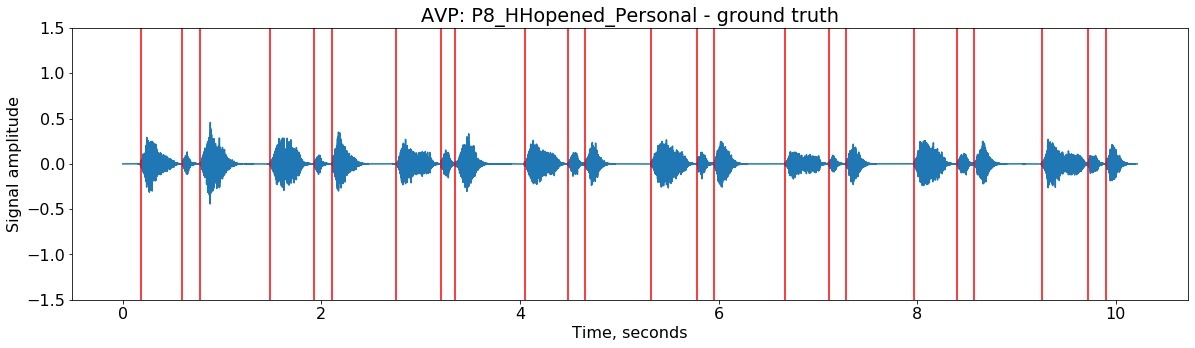

In [30]:
plot_track(track, onsets=annotation, title='AVP: P8_HHopened_Personal - ground truth')

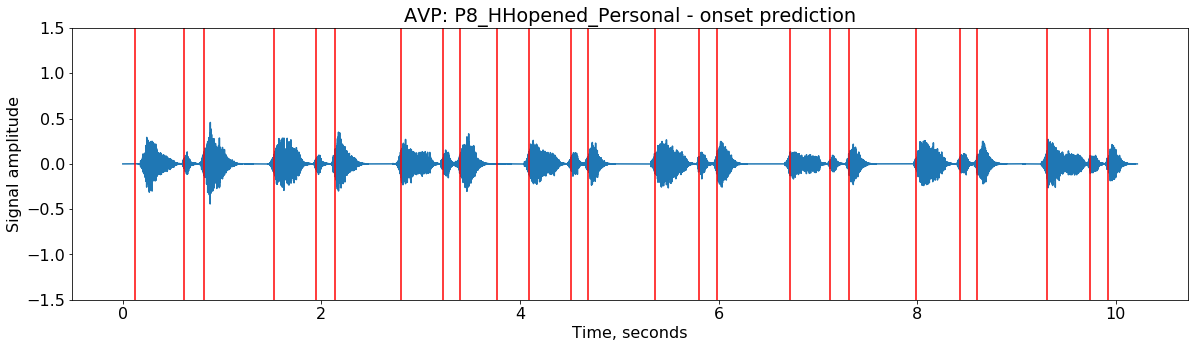

In [31]:
plot_track(track, onsets=onsets_pred, title='AVP: P8_HHopened_Personal - onset prediction')

In [32]:
avp_scores.mean()

HFC_F1          0.883038
HFC_prec        0.810385
HFC_rec         0.983208
Complex_F1      0.930681
Complex_prec    0.911859
Complex_rec     0.955990
dtype: float64

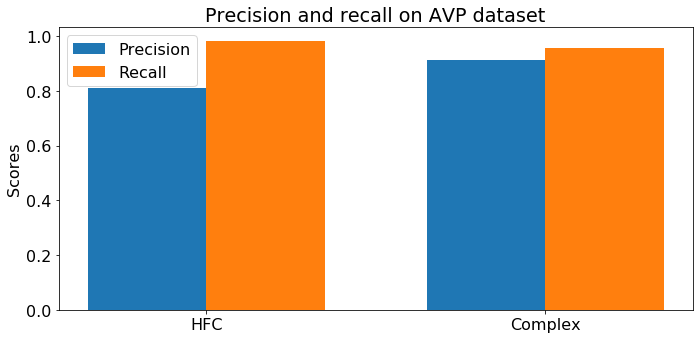

In [33]:
labels = ['HFC', 'Complex']
precs = ['HFC_prec', 'Complex_prec']
recs = ['HFC_rec', 'Complex_rec']

prec_rec_bar_plot(avp_scores, labels, precs, recs, title='Precision and recall on AVP dataset')